# Link Prediction with FastRP Embeddings
## TigerGraph ML Team

We will use FastRP embeddings of vertices to predict if there is a REVIEW edge between Users and Books.

## Connect to Database

In [1]:
import pyTigerGraph as tg 

conn = tg.TigerGraphConnection(host="http://104.155.129.195", graphname="Amazon_OGB_Test")
embeddingDim = 128

## Gather Data
Here, we run a query to get both user and book embeddings for all edges in the graph. We have to batch the query because the REST endpoint and timeout limits.

In [2]:
params = {
    "groups": 128,
    "groupId": 0,
}

users = []
books = []
ratings = []

for i in range(0, 1):
    print(i)
    params["groupId"] = i
    res = conn.runInstalledQuery("get_data", params=params)
    users += res[0]["@@userEmbeddings"]
    books += res[0]["@@bookEmbeddings"]
    ratings += res[0]["@@ratings"]


0


## Create Negative Samples
In order to have a proper dataset for classification, we need to generate negative samples. Negative samples are datapoints that are combinations of book and user embeddings that are not valid edges in the graph. To do this, we generate random shuffles of the book and user embeddings.

In [3]:
import numpy as np
import random as rd
positiveSamples = np.append(np.array(res[0]["@@userEmbeddings"]), np.array(res[0]["@@bookEmbeddings"]), axis=1)
negativeSamples = np.append(np.array(rd.sample(res[0]["@@userEmbeddings"], k=len(res[0]["@@userEmbeddings"]))), np.array(rd.sample(res[0]["@@bookEmbeddings"], k=len(res[0]["@@bookEmbeddings"]))), axis=1)

In [4]:
positiveSamples.shape

(176801, 256)

In [5]:
negativeSamples.shape

(176801, 256)

## Finish Dataset Prep
We have a dataset that now contains both positive and negative samples. First, create the labels for the dataset. Finally, we can split the dataset into train and test sets.

In [6]:
y = np.append(np.ones(positiveSamples.shape[0]), np.zeros(negativeSamples.shape[0]))
X = np.append(positiveSamples, negativeSamples, axis=0)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Perform Logistic Regression Classification
We can now perform logistic regression classification on the dataset. This doesn't perform that well.

In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train, y_train)

In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.48      0.50      0.49     35249
         1.0       0.48      0.46      0.47     35472

    accuracy                           0.48     70721
   macro avg       0.48      0.48      0.48     70721
weighted avg       0.48      0.48      0.48     70721



## Look at PCA representation
We can now look at the PCA representation of the dataset. Notably, the classes are not linearly seperable. Maybe a neural net would perform better?

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

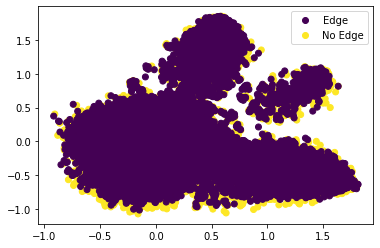

In [11]:
X_red = pca.fit_transform(X)

import matplotlib.pyplot as plt
plot = plt.scatter(X_red[:,0], X_red[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=["Edge", "No Edge"])
plt.show()

[0.01986761 0.01703494 0.0104346 ]


<function matplotlib.pyplot.show(close=None, block=None)>

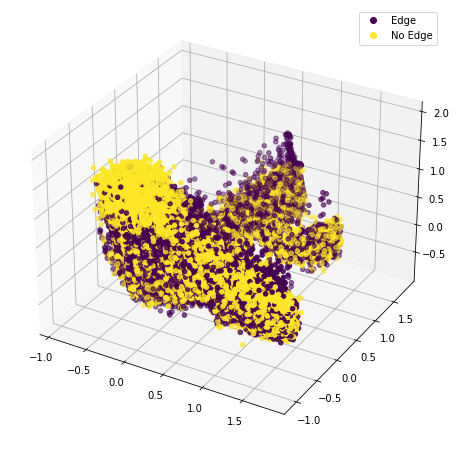

In [12]:
pca = PCA(n_components=3)
X_red = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], c=y)
ax.legend(handles=plot.legend_elements()[0], labels=["Edge", "No Edge"])
plt.show

## Neural Network
We can now use a neural network to perform classification. This performs **way** better than logistic regression.

In [13]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(256, 512, 5), random_state=1)

clf.fit(X_train, y_train)

/Users/parker.erickson/opt/anaconda3/envs/scotus/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(256, 512, 5), random_state=1,
              solver='lbfgs')

In [14]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71     35249
         1.0       0.71      0.71      0.71     35472

    accuracy                           0.71     70721
   macro avg       0.71      0.71      0.71     70721
weighted avg       0.71      0.71      0.71     70721

